## LightGBM

In [1]:
%%capture
!pip install lazypredict

In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgbm
import pickle
from sklearn.metrics import mean_squared_error
from lazypredict.Supervised import LazyRegressor

In [10]:
df = pd.read_csv('/workspace/kaggle_data/train.csv')
df = df.drop('full_text',axis = 1)
#df.head()
# 田中特徴量
df1 = pd.read_csv('/workspace/kaggle_data/conventions_eda_data.csv')
#df1.head()
# 丸ちゃん特徴量
df5 = pd.read_csv('/workspace/kaggle_data/mistake_features.csv')
df5.head()

,style,whitespace,locale-violation,misspelling,typographical,inconsistency,duplication,uncategorized,grammar_mistakes,error_length,sum_mistakes
0,0,1,0,8,2,0,0,0,2,58,13
1,2,0,0,25,5,0,0,0,8,145,40
2,0,0,0,7,2,0,0,0,1,56,10
3,1,0,0,3,11,0,0,0,1,76,16
4,0,1,0,13,2,0,0,0,2,170,18


In [11]:
# 田中
#df['word_count'] = df1['word_count']
#df['miss_count'] = df1['miss_count']
#df['bos_count'] = df1['bos_count']
#df['week_months'] = df1['week_months']
#df['small_count'] = df1['small_count']
#df['miss_rate'] = df1['miss_rate']
#df['small_rate'] = df1['small_rate']
df['log_miss_rate'] = df1['log_miss_rate']
df['log_small_rate'] = df1['log_small_rate']
#df['sample'] = df1['sample']

# fold
#df['fold'] = df3['fold']


df['target-cohesion'] = df['cohesion']
df['target-syntax'] = df['syntax']
df['target-vocabulary'] = df['vocabulary']
df['target-phraseology'] = df['phraseology']
df['target-grammar'] = df['grammar']
df['target-conventions'] = df['conventions']

# まるちゃん
df['style'] = df5['style']
df['whitespace'] = df5['whitespace']
#df['locale-violation'] = df5['locale-violation']  # 使えないかも
df['misspelling'] = df5['misspelling']
df['typographical'] = df5['typographical']
#df['inconsistency'] = df5['inconsistency']　　　　　　# 使えないかも
#df['duplication'] = df5['duplication']　　　　　　　　　# 使えないかも
#df['uncategorized'] = df5['uncategorized']　　　　　　　# 使えないかも
df['grammar_mistakes'] = df5['grammar_mistakes']
df['error_length'] = df5['error_length']
df['sum_mistakes'] = df5['sum_mistakes']

target_list = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions', 'text_id']
df = df.drop(target_list, axis = 1)
df.head()

,log_miss_rate,log_small_rate,target-cohesion,target-syntax,target-vocabulary,target-phraseology,target-grammar,target-conventions,style,whitespace,misspelling,typographical,grammar_mistakes,error_length,sum_mistakes
0,0.00,0.06,3.50,3.50,3.00,3.00,4.00,3.00,0,1,8,2,2,58,13
1,0.00,0.01,2.50,2.50,3.00,2.00,2.00,2.50,2,0,25,5,8,145,40
2,0.01,0.01,3.00,3.50,3.00,3.00,3.00,2.50,0,0,7,2,1,56,10
3,0.00,0.00,4.50,4.50,4.50,4.50,4.00,5.00,1,0,3,11,1,76,16
4,0.03,0.00,2.50,3.00,3.00,3.00,2.50,2.50,0,1,13,2,2,170,18


In [12]:
df.to_csv('/workspace/kaggle_data/features.csv')

## モデルの学習

In [13]:
from sklearn.linear_model import LinearRegression

num_fold = 4

data_path = '/workspace/kaggle_data/4fold_dataset/'
#save_path = '/workspace/kaggle_data/save_models/4-fold/'
save_path = '/workspace/kaggle_data/save_models/linear-4-fold/'
#data_path = '/workspace/kaggle_data/10fold_dataset/'
#save_path = '/workspace/kaggle_data/save_models/10-fold/'


In [14]:
def train_lr(t_list, column, fold, df, data_path, save_path):
    print(f'fold:{fold}')
    print(f'columns:{column}')
    
    deberta_df = pd.read_csv(data_path + f'fold{fold}.csv')
    df['cohesion'] = deberta_df['cohesion']
    df['syntax'] = deberta_df['syntax']
    df['vocabulary'] = deberta_df['vocabulary']
    df['phraseology'] = deberta_df['phraseology']
    df['grammar'] = deberta_df['grammar']
    df['conventions'] = deberta_df['conventions']
    df['fold'] = deberta_df['fold']
    
    df_train = df[df.fold != fold]
    df_valid = df[df.fold == fold]
        
    # 学習データ
    x_train = df_train.drop(t_list, axis = 1)
    y_train = df_train[f'target-{column}']
        
    # 評価用データ
    x_valid = df_valid.drop(t_list, axis = 1)
    y_valid = df_valid[f'target-{column}']
    
    reg = LazyRegressor(verbose=1,ignore_warnings=True,predictions=True)
    models, predictions = reg.fit(x_train, x_valid, y_train, y_valid)
    
        
    #rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(models)
    
    #file = f'lgbm_{column}_{fold}.pkl'
    #pickle.dump(lr, open(save_path + file, 'wb'))
    
    return #rmse, lr

## モデルを一つ作成

In [15]:
input_df = pd.read_csv('/workspace/kaggle_data/features.csv',index_col=0)
fold = 0
columns_name = 'conventions'
target_list = ['target-cohesion','target-syntax','target-vocabulary','target-phraseology','target-grammar','target-conventions', 'fold']

train_lr(target_list, columns_name, fold, input_df, data_path, save_path)

fold:0
columns:conventions


  5%|▍         | 2/42 [00:00<00:06,  5.73it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5388591163922961, 'Adjusted R-Squared': 0.5316687699742966, 'RMSE': 0.4480699664189301, 'Time taken': 0.2194051742553711}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5009234698288283, 'Adjusted R-Squared': 0.49314161125027567, 'RMSE': 0.4661359456600626, 'Time taken': 0.14252042770385742}


 19%|█▉        | 8/42 [00:00<00:01, 18.60it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.551871948605521, 'Adjusted R-Squared': 0.544884504976709, 'RMSE': 0.4417027326377005, 'Time taken': 0.0988767147064209}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.13924989914125985, 'Adjusted R-Squared': 0.12582863977236058, 'RMSE': 0.6121636842202571, 'Time taken': 0.028383731842041016}
{'Model': 'DummyRegressor', 'R-Squared': -1.277543581590379e-05, 'Adjusted R-Squared': -0.015605490229513741, 'RMSE': 0.6598296014724808, 'Time taken': 0.00438690185546875}
{'Model': 'ElasticNet', 'R-Squared': 0.059703645877888456, 'Adjusted R-Squared': 0.04504206031465385, 'RMSE': 0.6398252824366856, 'Time taken': 0.023259639739990234}
{'Model': 'ElasticNetCV', 'R-Squared': 0.5523610452614404, 'Adjusted R-Squared': 0.545381227879862, 'RMSE': 0.44146162487021134, 'Time taken': 0.047911643981933594}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.12398420840297386, 'Adjusted R-Squared': 0.11032491851320736, 'RMSE': 0.6175682901890566, 'Time taken': 0.02387

 26%|██▌       | 11/42 [00:01<00:06,  4.76it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.8750167133988835, 'Adjusted R-Squared': -0.9042529407387829, 'RMSE': 0.9035071476055122, 'Time taken': 0.6919782161712646}


 31%|███       | 13/42 [00:02<00:07,  3.70it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5430645791414652, 'Adjusted R-Squared': 0.5359398064669558, 'RMSE': 0.4460221568712697, 'Time taken': 0.6707460880279541}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5265264325019341, 'Adjusted R-Squared': 0.5191437885180765, 'RMSE': 0.4540219925627082, 'Time taken': 0.17919135093688965}
{'Model': 'HuberRegressor', 'R-Squared': 0.5496697400444434, 'Adjusted R-Squared': 0.5426479584443047, 'RMSE': 0.44278671903063066, 'Time taken': 0.035805463790893555}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.45266627283730043, 'Adjusted R-Squared': 0.4441319631622064, 'RMSE': 0.4881520598520837, 'Time taken': 0.036492109298706055}


 48%|████▊     | 20/42 [00:03<00:02,  7.57it/s]

{'Model': 'KernelRidge', 'R-Squared': -21.499172556209732, 'Adjusted R-Squared': -21.84999125511113, 'RMSE': 3.1297690693420606, 'Time taken': 0.23557233810424805}
{'Model': 'Lars', 'R-Squared': 0.5357068769102722, 'Adjusted R-Squared': 0.5284673791489978, 'RMSE': 0.44959880322671514, 'Time taken': 0.007524251937866211}
{'Model': 'LarsCV', 'R-Squared': 0.5538088990164165, 'Adjusted R-Squared': 0.5468516573170883, 'RMSE': 0.44074710981286047, 'Time taken': 0.0363154411315918}
{'Model': 'Lasso', 'R-Squared': -1.277543581590379e-05, 'Adjusted R-Squared': -0.015605490229513741, 'RMSE': 0.6598296014724808, 'Time taken': 0.010342121124267578}
{'Model': 'LassoCV', 'R-Squared': 0.5522202662614222, 'Adjusted R-Squared': 0.5452382537810909, 'RMSE': 0.44153103755190265, 'Time taken': 0.05009961128234863}
{'Model': 'LassoLars', 'R-Squared': -1.277543581590379e-05, 'Adjusted R-Squared': -0.015605490229513741, 'RMSE': 0.6598296014724808, 'Time taken': 0.02335190773010254}


 57%|█████▋    | 24/42 [00:03<00:01,  9.51it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.552287798978027, 'Adjusted R-Squared': 0.5453068395026324, 'RMSE': 0.44149774114238993, 'Time taken': 0.0763545036315918}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5524932941141114, 'Adjusted R-Squared': 0.5455155388248304, 'RMSE': 0.44139640813079745, 'Time taken': 0.08296322822570801}
{'Model': 'LinearRegression', 'R-Squared': 0.5513066560550326, 'Adjusted R-Squared': 0.5443103980933127, 'RMSE': 0.4419812384907498, 'Time taken': 0.07672452926635742}
{'Model': 'LinearSVR', 'R-Squared': 0.5485005622320844, 'Adjusted R-Squared': 0.5414605502086762, 'RMSE': 0.4433611428140257, 'Time taken': 0.10839486122131348}


 62%|██████▏   | 26/42 [00:04<00:03,  4.49it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5100338294159239, 'Adjusted R-Squared': 0.5023940242612865, 'RMSE': 0.4618618264861634, 'Time taken': 1.003502368927002}


 67%|██████▋   | 28/42 [00:04<00:02,  4.96it/s]

{'Model': 'NuSVR', 'R-Squared': 0.5322139519880704, 'Adjusted R-Squared': 0.5249199907404831, 'RMSE': 0.4512868234092641, 'Time taken': 0.28371644020080566}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5526157880149098, 'Adjusted R-Squared': 0.5456399427136871, 'RMSE': 0.44133599331734824, 'Time taken': 0.005178689956665039}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5489112359731727, 'Adjusted R-Squared': 0.5418776273864758, 'RMSE': 0.4431594612768904, 'Time taken': 0.008871078491210938}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.08617032023215898, 'Adjusted R-Squared': 0.07192141670147534, 'RMSE': 0.6307563778363712, 'Time taken': 0.006154060363769531}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5494499421754209, 'Adjusted R-Squared': 0.5424247333735823, 'RMSE': 0.4428947638516935, 'Time taken': 0.006886720657348633}


 76%|███████▌  | 32/42 [02:37<02:47, 16.77s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.01575557650795223, 'Adjusted R-Squared': -0.03159376117283719, 'RMSE': 0.6650030368767326, 'Time taken': 152.55125498771667}
{'Model': 'RANSACRegressor', 'R-Squared': -0.3003916949835084, 'Adjusted R-Squared': -0.3206680727639166, 'RMSE': 0.7524300201958839, 'Time taken': 0.060427188873291016}


 81%|████████  | 34/42 [02:38<01:43, 12.96s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.534452387110253, 'Adjusted R-Squared': 0.5271933286972112, 'RMSE': 0.45020578684780077, 'Time taken': 1.3922357559204102}
{'Model': 'Ridge', 'R-Squared': 0.5513823175249195, 'Adjusted R-Squared': 0.5443872393158486, 'RMSE': 0.4419439721032579, 'Time taken': 0.0060503482818603516}
{'Model': 'RidgeCV', 'R-Squared': 0.5520652752162478, 'Adjusted R-Squared': 0.545080846035628, 'RMSE': 0.44160744502538407, 'Time taken': 0.011798381805419922}
{'Model': 'SGDRegressor', 'R-Squared': 0.5561157520013021, 'Adjusted R-Squared': 0.5491944799431103, 'RMSE': 0.4396062798497485, 'Time taken': 0.011854171752929688}


 90%|█████████ | 38/42 [02:39<00:31,  7.76s/it]

{'Model': 'SVR', 'R-Squared': 0.5221152908748076, 'Adjusted R-Squared': 0.5146638660963483, 'RMSE': 0.45613204934081497, 'Time taken': 0.41259050369262695}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.5513066560550326, 'Adjusted R-Squared': 0.5443103980933127, 'RMSE': 0.4419812384907498, 'Time taken': 0.011428356170654297}
{'Model': 'TweedieRegressor', 'R-Squared': 0.5406962949311467, 'Adjusted R-Squared': 0.5335345947481605, 'RMSE': 0.4471765235671145, 'Time taken': 0.027156352996826172}


100%|██████████| 42/42 [02:39<00:00,  3.80s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.4725075222783178, 'Adjusted R-Squared': 0.4642825875945078, 'RMSE': 0.47922245134900243, 'Time taken': 0.2510080337524414}
{'Model': 'LGBMRegressor', 'R-Squared': 0.5231171426363285, 'Adjusted R-Squared': 0.515681339247082, 'RMSE': 0.4556536740709381, 'Time taken': 0.07076287269592285}
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
SGDRegressor                                 0.55       0.56  0.44        0.01
LarsCV                                       0.55       0.55  0.44        0.04
OrthogonalMatchingPursuit                    0.55       0.55  0.44        0.01
LassoLarsIC                                  0.55       0.55  0.44        0.08
ElasticNetCV                                 0.55       0.55  0.44        0.05
LassoLarsCV                                  0.55       0.55  0.44        0.08
LassoCV                                 

## 複数のモデルを作成

In [45]:
input_df = pd.read_csv('/workspace/kaggle_data/features.csv',index_col=0)
column_list = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
target_list = ['target-cohesion','target-syntax','target-vocabulary','target-phraseology','target-grammar','target-conventions', 'fold']


score_list = []
for i in column_list:
    columns_name = i
    score_l = []
    for j in range(num_fold):
        fold = j
        score, models = train_lr(target_list, columns_name, fold, input_df, data_path, save_path)
        score_l.append(score)
    score_list.append(score_l)

fold:0
columns:cohesion
0.48163520946591154
fold:1
columns:cohesion
0.4944749265830755
fold:2
columns:cohesion
0.48388129173244326
fold:3
columns:cohesion
0.48354603887218256
fold:0
columns:syntax
0.4417261153143638
fold:1
columns:syntax
0.4465423545345618
fold:2
columns:syntax
0.455118772916972
fold:3
columns:syntax
0.445404394438398
fold:0
columns:vocabulary
0.415228161859009
fold:1
columns:vocabulary
0.4278479926934982
fold:2
columns:vocabulary
0.4215183830076695
fold:3
columns:vocabulary
0.4109452733843547
fold:0
columns:phraseology
0.46213185435503495
fold:1
columns:phraseology
0.4596532939455766
fold:2
columns:phraseology
0.47050502700802926
fold:3
columns:phraseology
0.43630163997725563
fold:0
columns:grammar
0.471759423050848
fold:1
columns:grammar
0.47875091547830645
fold:2
columns:grammar
0.4920073722227463
fold:3
columns:grammar
0.4631084674498509
fold:0
columns:conventions
0.4410319317849214
fold:1
columns:conventions
0.4498589822533331
fold:2
columns:conventions
0.46072027

In [46]:
score_list

[[0.48163520946591154,
  0.4944749265830755,
  0.48388129173244326,
  0.48354603887218256],
 [0.4417261153143638,
  0.4465423545345618,
  0.455118772916972,
  0.445404394438398],
 [0.415228161859009,
  0.4278479926934982,
  0.4215183830076695,
  0.4109452733843547],
 [0.46213185435503495,
  0.4596532939455766,
  0.47050502700802926,
  0.43630163997725563],
 [0.471759423050848,
  0.47875091547830645,
  0.4920073722227463,
  0.4631084674498509],
 [0.4410319317849214,
  0.4498589822533331,
  0.46072027818229366,
  0.43554546310925046]]

In [47]:
a = np.mean(score_list, axis=1)
a

array([0.48588437, 0.44719791, 0.41888495, 0.45714795, 0.47640654,
       0.44678916])

In [ ]:
array([0.48589099, 0.4464214 , 0.41856567, 0.45673136, 0.47393116,
       0.44643672])

In [ ]:
array([0.48504205, 0.44759053, 0.41836747, 0.45859022, 0.47132155,
       0.44778736])

In [ ]:
array([0.48560059, 0.44780822, 0.41822542, 0.45880633, 0.47248896,
       0.44809342])

In [299]:
np.mean(a)

0.4547831953513021

In [ ]:
0.48210887, 0.44654392, 0.41677376, 0.45779343, 0.4719515 ,0.44809007
0.4538403352286591

## モデルの読み込み

In [8]:
fold = 0
column = 'conventions'

t_list = ['target-cohesion','target-syntax','target-vocabulary','target-phraseology','target-grammar','target-conventions', 'fold']


lgbm = pickle.load(open(save_path + f'lgbm_{column}_{fold}.pkl', 'rb'))

df = pd.read_csv('/workspace/kaggle_data/features.csv',index_col=0)
deberta_df = pd.read_csv(data_path + f'fold{fold}.csv')
df['cohesion'] = deberta_df['cohesion']
df['syntax'] = deberta_df['syntax']
df['vocabulary'] = deberta_df['vocabulary']
df['phraseology'] = deberta_df['phraseology']
df['grammar'] = deberta_df['grammar']
df['conventions'] = deberta_df['conventions']
df['fold'] = deberta_df['fold']
df = df[df.fold == fold]
X = df.drop(t_list, axis = 1)
y = df[f'target-{column}']


# 予測
preds = lgbm.predict(X)
rmse = np.sqrt(mean_squared_error(y, preds))

print('RMSE : {:.4f}'.format(rmse))

RMSE : 0.4461


## 特徴量重要度の可視化

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

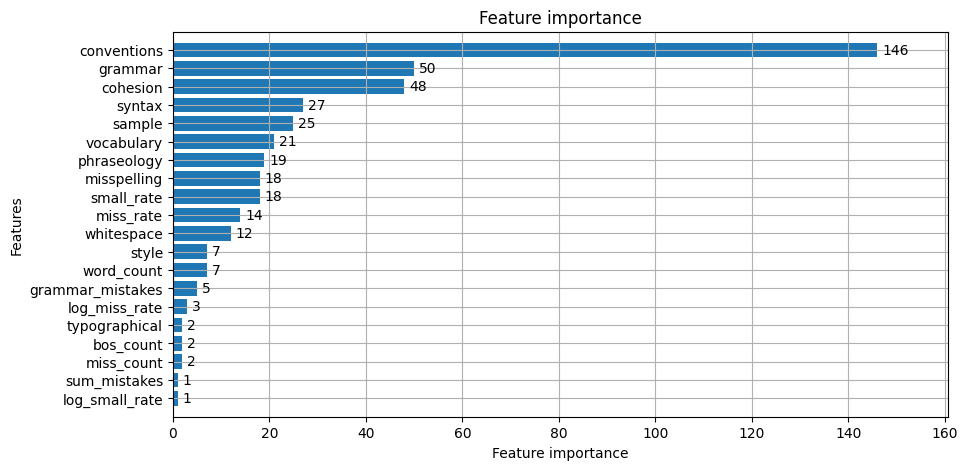

In [95]:
lgbm.plot_importance(models, height = 0.8 ,figsize = (10,5),importance_type='split',)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

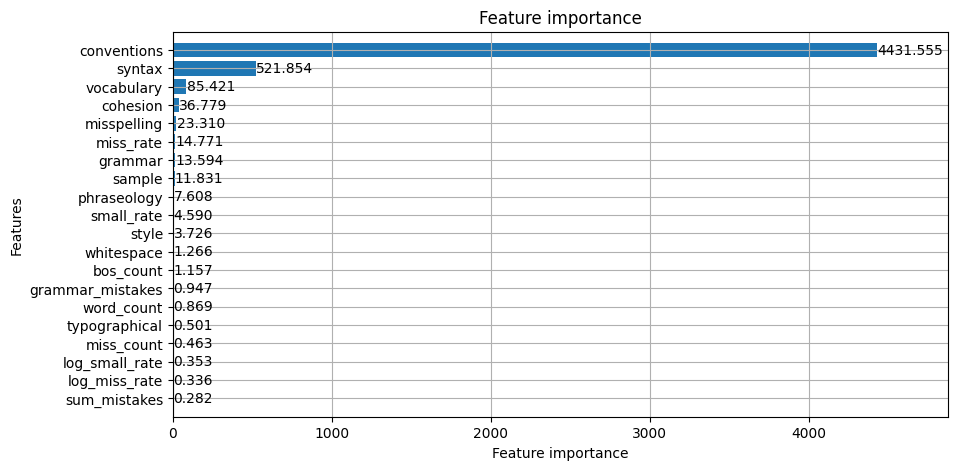

In [96]:
lgbm.plot_importance(models, height = 0.8 ,figsize = (10,5),importance_type='gain',)

In [63]:
(0.488253 + 0.443372 + 0.452601 + 0.456041)/4

0.46006674999999997

In [42]:
0.44905
0.42415
0.430138
0.413216

0.413216

In [ ]:
0.447626
0.423544
0.430148
0.415338

In [53]:
(0.444326 + 0.419902 + 0.424559 + 0.40874)/4

0.42438175